In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw

In [2]:
import importlib
import sys
from pathlib import Path
import os 
sys.path.append(str(Path(os.getcwd()).parent / "src"))

import active_gel_fem
importlib.reload(active_gel_fem)

import utils 
importlib.reload(utils)

from ngsolve.webgui import Draw

In [3]:
def plot_frame(n_samples, rho, vx, vy, nx, ny, filename, stride=3):
    X = np.linspace(0, 1, n_samples)
    Y = np.linspace(0, 1, n_samples)
    X, Y = np.meshgrid(X, Y)

    # Plot the contour for rho_vals
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axes[0].contourf(X, Y, rho, levels=100, cmap='Greys')
    fig.colorbar(im0, ax=axes[0])
    axes[0].set_title(r'actin density $\rho$')

    mag = np.sqrt(vx**2+vy**2)
    im1 = axes[1].contourf(X, Y, mag, levels=100, cmap='Blues')
    axes[1].set_title(r'velocity $v$')
    fig.colorbar(im1, ax=axes[1])
    axes[1].quiver(X[::stride, ::stride], Y[::stride, ::stride], 
            (vx/mag)[::stride, ::stride], (vy/mag)[::stride, ::stride], 
            color='orange', 
            width=0.003,     # Increase width to make arrow shafts thicker
            headwidth=4,     # Increase headwidth for wider arrowheads
            headlength=5,    # Increase headlength for longer arrowheads
            headaxislength=7 # Increase headaxislength for more pronounced heads
    ) 

    mag = np.sqrt(nx**2+ny**2)
    im2 = axes[2].contourf(X, Y, mag, levels=100, cmap='Blues')
    axes[2].set_title(r'nematic order $Q$')
    fig.colorbar(im2, ax=axes[2])
    plt.quiver(X[::stride, ::stride], Y[::stride, ::stride], 
            (nx/mag)[::stride, ::stride], (ny/mag)[::stride, ::stride], 
            color='orange', 
            width=0.003,     # Increase width to make arrow shafts thicker
            headlength=0,    
            headaxislength=0 
    ) 

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

def run_sim(eta, beta1, beta2, chi0_active, chi1_active, T, source):
    chi0 = chi0_active
    chi1 = chi1_active
    rho0 = 1 + 1*source


    sim = active_gel_fem.NematicActiveGel2D(
                        width=1, height=1, maxh=0.03,
                        gamma=eta, eta_1=eta, eta_2=0,
                        k=1, D=1e-4,
                        kappa = 1e-4,
                        beta1 = beta1, beta2 = beta2,   
                        chi0 = chi0,  chi1 = chi1,
                        Qsq = -1 + 2*source, rho0 = rho0 
                    )
    
    for i in range(len(sim.density.vec.data)): 
        sim.density.vec.data[i] = np.random.normal(1, 0.05)
        sim.nematic_xx.vec.data[i] = np.random.normal(0, 0.05)

    sim.simulate(
        tend=T,
        tau=0.05,
        save_interval=20 # save once a second 
    )

    return sim 
    
    


In [ ]:

# parameters for isotropic outward flow + no source term for nematic order + no source for spontanous nematic order 
# T = 5
# tau = 0.01 
# eta = 1 
# chi0 = 10
# chi1 = 6
# beta_prod = 1
# beta2 = 2
# beta1 = 10 
# kappa = 0.01 


T = 100
tau = 0.1
chi0 = 0.1
chi1 = 0.3
beta_prod = 1
beta2 = 1
beta1 = beta_prod/beta2
eta = 1 



tanh = lambda arg: (exp(arg) - exp(-arg))/(exp(arg)+exp(-arg)) 
left_edge = 0.5 - 0.05
right_edge = 0.5 + 0.05
left_transition = 0.5 * (tanh((x - left_edge)/0.005))
right_transition = 0.5 * (tanh((right_edge - x)/0.005))

half_length = lambda t: 0.
bottom_transition = lambda t: 0.5 * (tanh((y - (0.1-half_length(t)))/0.01))
top_transition = lambda t: 0.5 * (tanh((0.9 + half_length(t)- y)/0.01))
source = lambda t: 1*(left_transition + right_transition) *(top_transition(t) + bottom_transition(t))


sim = active_gel_fem.NematicActiveGel2D(
                    width=1, height=1, maxh=0.03,
                    gamma=eta, eta_1=eta, eta_2=0,
                    k=1, D=1e-4,
                    kappa =1e-4,
                    beta1 = beta1, beta2 = beta2,   
                    chi0 = chi0,  chi1 = chi1,
                    Qsq = lambda t: -1+2*source(t), 
                    rho0 = lambda t: 1+0.1*source(t))

sim.density.Set(1)

# for i in range(len(sim.density.vec.data)): 
#     sim.density.vec.data[i] = np.random.normal(1, 0.05)
#     sim.nematic_xx.vec.data[i] = np.random.normal(0, 0.05)

sim.simulate(
    tend=T,
    tau=tau,
    save_interval=int(1/tau) # save once a second 
)

  2%|▏         | 21/1000 [00:00<00:12, 81.06it/s]

craete bilinearformapplication


100%|██████████| 1000/1000 [00:07<00:00, 130.65it/s]


In [11]:
sim.visualize(animate=False)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [14]:
filename = 'sim_data/test'

n_samples = 50
data= sim.export_to_npy(filename, n_samples=n_samples)

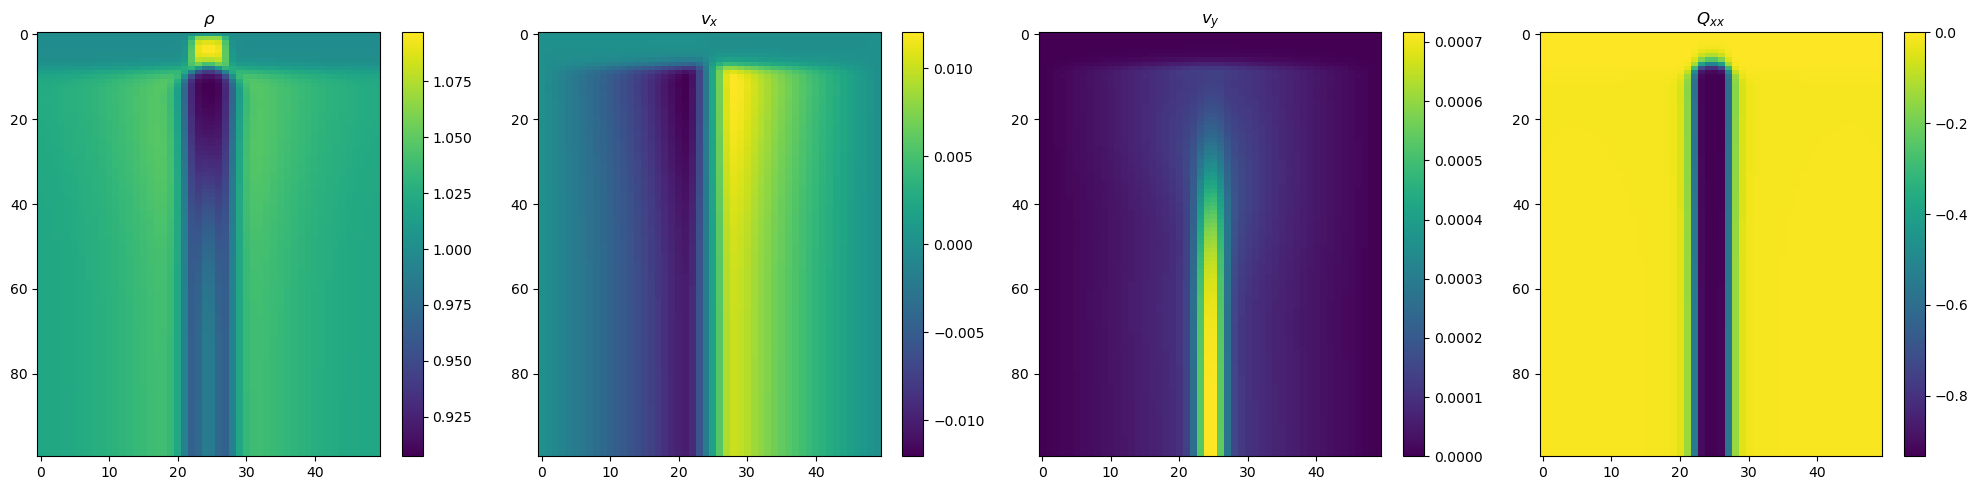

In [15]:
# ...existing code...

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

im0 = axes[0].imshow(data[:, 24, :, 0], aspect='auto', interpolation='none')
fig.colorbar(im0, ax=axes[0])
axes[0].set_title(r'$\rho$')

im1 = axes[1].imshow(data[:, 24, :, 1], aspect='auto', interpolation='none')
fig.colorbar(im1, ax=axes[1])
axes[1].set_title(r'$v_x$')

im2 = axes[2].imshow(data[:, 24, :, 2], aspect='auto', interpolation='none')
fig.colorbar(im2, ax=axes[2])
axes[2].set_title(r'$v_y$')

im3 = axes[3].imshow(data[:, 24, :, -2], aspect='auto', interpolation='none')
fig.colorbar(im3, ax=axes[3])
axes[3].set_title(r'$Q_{xx}$')

plt.tight_layout()
plt.show()
# ...existing code...

/var/folders/5n/0rvnm9350db7gk5vdnj3tn6h0000gn/T/ipykernel_68086/237348254.py:18: RuntimeWarning: invalid value encountered in divide
  (vx/mag)[::stride, ::stride], (vy/mag)[::stride, ::stride],


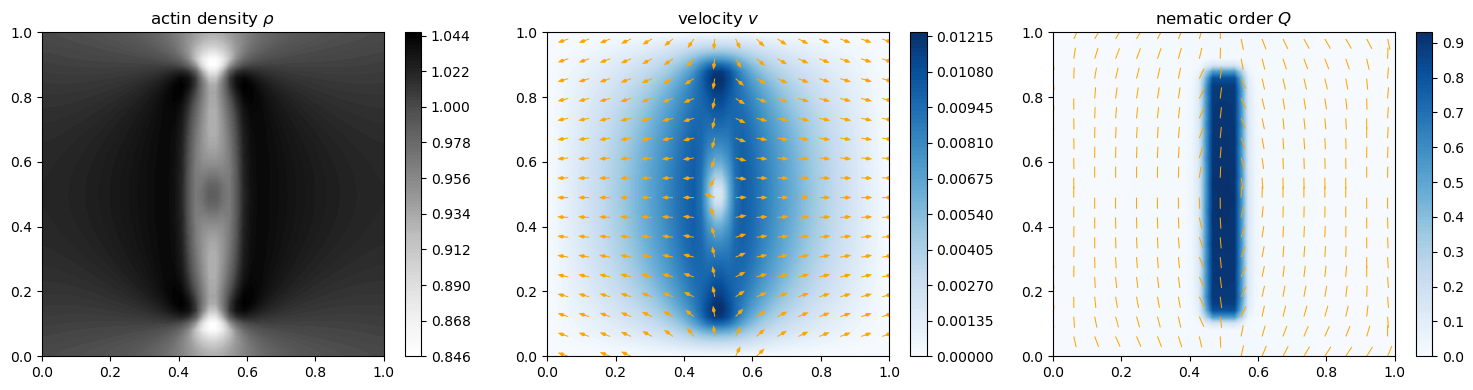

In [17]:
t = -1
rho, vx, vy, Q, q = np.rollaxis(data[t], -1)
nx, ny = utils.nematic_to_vector(Q, q)

filename = '../figures/nem_dep_zone_2d.png'
plot_frame(n_samples, rho, vx, vy, nx, ny, filename, stride=3)


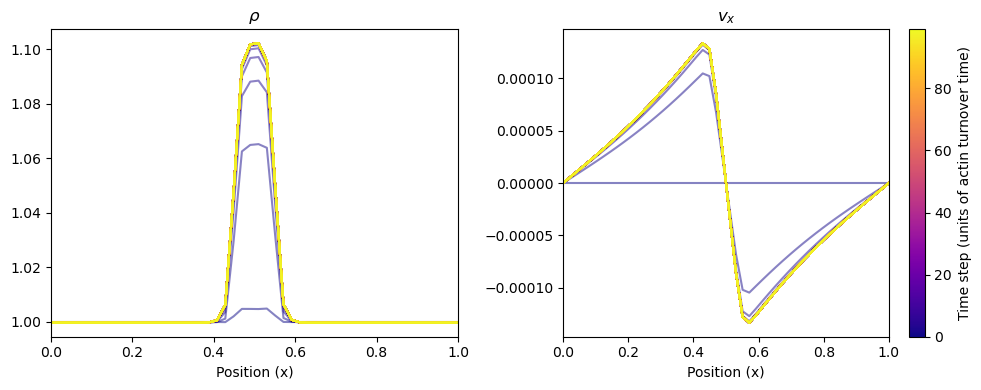

In [9]:
rho = data[:, 24,  :, 0] 
vx = data[:, 24, :, 1]

x_grid  = np.linspace(0, 1, n_samples)


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

colors = plt.cm.plasma(np.linspace(0, 1, T))
for i in range(T): 
    axes[0].plot(x_grid, rho[i], '-', alpha=0.5, color=colors[i])
    axes[1].plot(x_grid, vx[i], '-', alpha=0.5, color=colors[i])
axes[0].set_title(r'$\rho$')
axes[1].set_title(r'$v_x$')

# Add colorbar for time
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=0, vmax=T-1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], shrink=1)
cbar.set_label('Time step (units of actin turnover time)')

axes[0].set_xlabel('Position (x)') 
axes[1].set_xlabel('Position (x)') 
axes[0].set_xlim(0, 1)

plt.tight_layout()
plt.savefig('../figures/nem_kymo_no_phase_separation.pdf')
plt.show()